## Local Inference

In [1]:
%matplotlib inline
import os, json, cv2, numpy as np, matplotlib.pyplot as plt
import copy

import torch
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.transforms import functional as F

import time

c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_model(num_keypoints, weights_path=None):
    
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)

    if weights_path:
        state_dict = torch.load(weights_path)
        
        # update state_dict keys
        # for key in list(state_dict.keys()):
        #     state_dict[key.replace('.0.0', '.0').replace('.1.0', '.1').replace('.2.0', '.2').replace('.3.0', '.3').replace('rpn.head.conv.0.0.', 'rpn.head.conv.').replace('rpn.head.conv.0.', 'rpn.head.conv.')] = state_dict.pop(key)

        model.load_state_dict(state_dict)        
        
    return model

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = get_model(num_keypoints = 4, weights_path='./assets/keypoint_model/weights/keypointsrcnn_weights 001.pth')
model.to(device)

c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
c:\Users\Hisku\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or 

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [20]:
import cv2

# Open the video file
video = cv2.VideoCapture("./pfd_video_dataset/20221014_124610.mp4")

# Check if video is opened successfully
if not video.isOpened():
    print("Error opening video file")

keypoints_main = []
bboxes_main = []

# Read until video is completed
while(video.isOpened()):
    # Capture frame-by-frame
    ret, frame = video.read()
    
    if ret == True:
        if int(time.time()) % 10 == 0:
            frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frame_tensor = F.to_tensor(frame_np)
            frame_tensor = frame_tensor.to(device)
            
            images = [frame_tensor]

            with torch.no_grad():
                model.to(device)
                model.eval()
                output = model(images)
            
            frame_tensor = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
            scores = output[0]['scores'].detach().cpu().numpy()
            
            high_scores_idxs = np.where(scores > 0.8)[0].tolist() # Indexes of boxes with scores > 0.7
            post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

            keypoints = []
            for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
                keypoints.append([list(map(int, kp[:2])) for kp in kps])
                
            bboxes = []
            for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
                bboxes.append(list(map(int, bbox.tolist())))

            if(len(keypoints) != 0):
                keypoints_main = keypoints
            
            if(len(bboxes) != 0):
                bboxes_main = bboxes

        if(len(keypoints_main) != 0):
            points = np.array(keypoints_main, np.int32)
            points = points.reshape((-1, 1, 2))

            # Draw a keypoints on the frame
            # cv2.polylines(frame, [points], isClosed=True, color=(0, 0, 0), thickness=8)
            for point in points:
                center = (point[0][0], point[0][1])
                radius = 15

                # Draw the keypoints using the circle() function
                cv2.circle(frame, center, radius, (0, 0, 255), -1)

        if(len(bboxes_main) != 0):
            # draw a bbox on the frame
            cv2.rectangle(frame, (bboxes_main[0][0], bboxes_main[0][1]),  (bboxes_main[0][2], bboxes_main[0][3]), color=(0, 255, 0), thickness=8)

        # Display the resulting frame
        frame = cv2.resize(frame, (600, 800), interpolation=cv2.INTER_AREA)
        cv2.imshow('Frame', frame)
        
        # Press Q on keyboard to exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Break the loop
    else:
        break

# Release the video
video.release()

# Close all windows
cv2.destroyAllWindows()

In [4]:
import cv2

# Create a VideoCapture object
cap = cv2.VideoCapture(0) # 0 means the default camera

keypoints_main = []
bboxes_main = []

while True:
    # Read a frame from the video
    ret, frame = cap.read()

    if int(time.time()) % 10 == 0:
        frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame_tensor = F.to_tensor(frame_np)
        frame_tensor = frame_tensor.to(device)
        images = [frame_tensor]


        with torch.no_grad():
            model.to(device)
            model.eval()
            output = model(images)
        
        frame_tensor = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
        scores = output[0]['scores'].detach().cpu().numpy()
        
        high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
        post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

        keypoints = []
        for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            keypoints.append([list(map(int, kp[:2])) for kp in kps])
            
        bboxes = []
        for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
            bboxes.append(list(map(int, bbox.tolist())))
    
        if(len(keypoints) != 0):
            print(keypoints)
            keypoints_main = keypoints
        
        if(len(bboxes) != 0):
            print(bboxes)
            bboxes_main = bboxes

        if(len(keypoints_main) != 0):
            points = np.array(keypoints_main, np.int32)
            points = points.reshape((-1, 1, 2))

            # Draw a keypoints on the frame
            # cv2.polylines(frame, [points], isClosed=True, color=(0, 0, 0), thickness=8)
            for point in points:
                center = (point[0][0], point[0][1])
                radius = 15

                # Draw the keypoints using the circle() function
                cv2.circle(frame, center, radius, (255, 0, 0), -1)

        if(len(bboxes_main) != 0):
            # draw a bbox on the frame
            cv2.rectangle(frame, (bboxes_main[0][0], bboxes_main[0][1]),  (bboxes_main[0][2], bboxes_main[0][3]), color=(0, 255, 0), thickness=8)
            print(keypoints, bboxes)
            
    # Display the frame with the bounding box
    cv2.imshow("Live Video with Bounding Box", frame)

    # `Exit the loop if the 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object
cap.release()

# Close all windows
cv2.destroyAllWindows()

In [11]:
keypoints_classes_ids2names = {0: '', 1: ''}

def visualize(image, bboxes, keypoints, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 3, (255,0,0), 4)
            # image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 3, (255,0,0), 4)
                # image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

[[[1020, 579], [991, 579], [1020, 579], [1020, 579]]]
[[470, 577, 1022, 1085]]


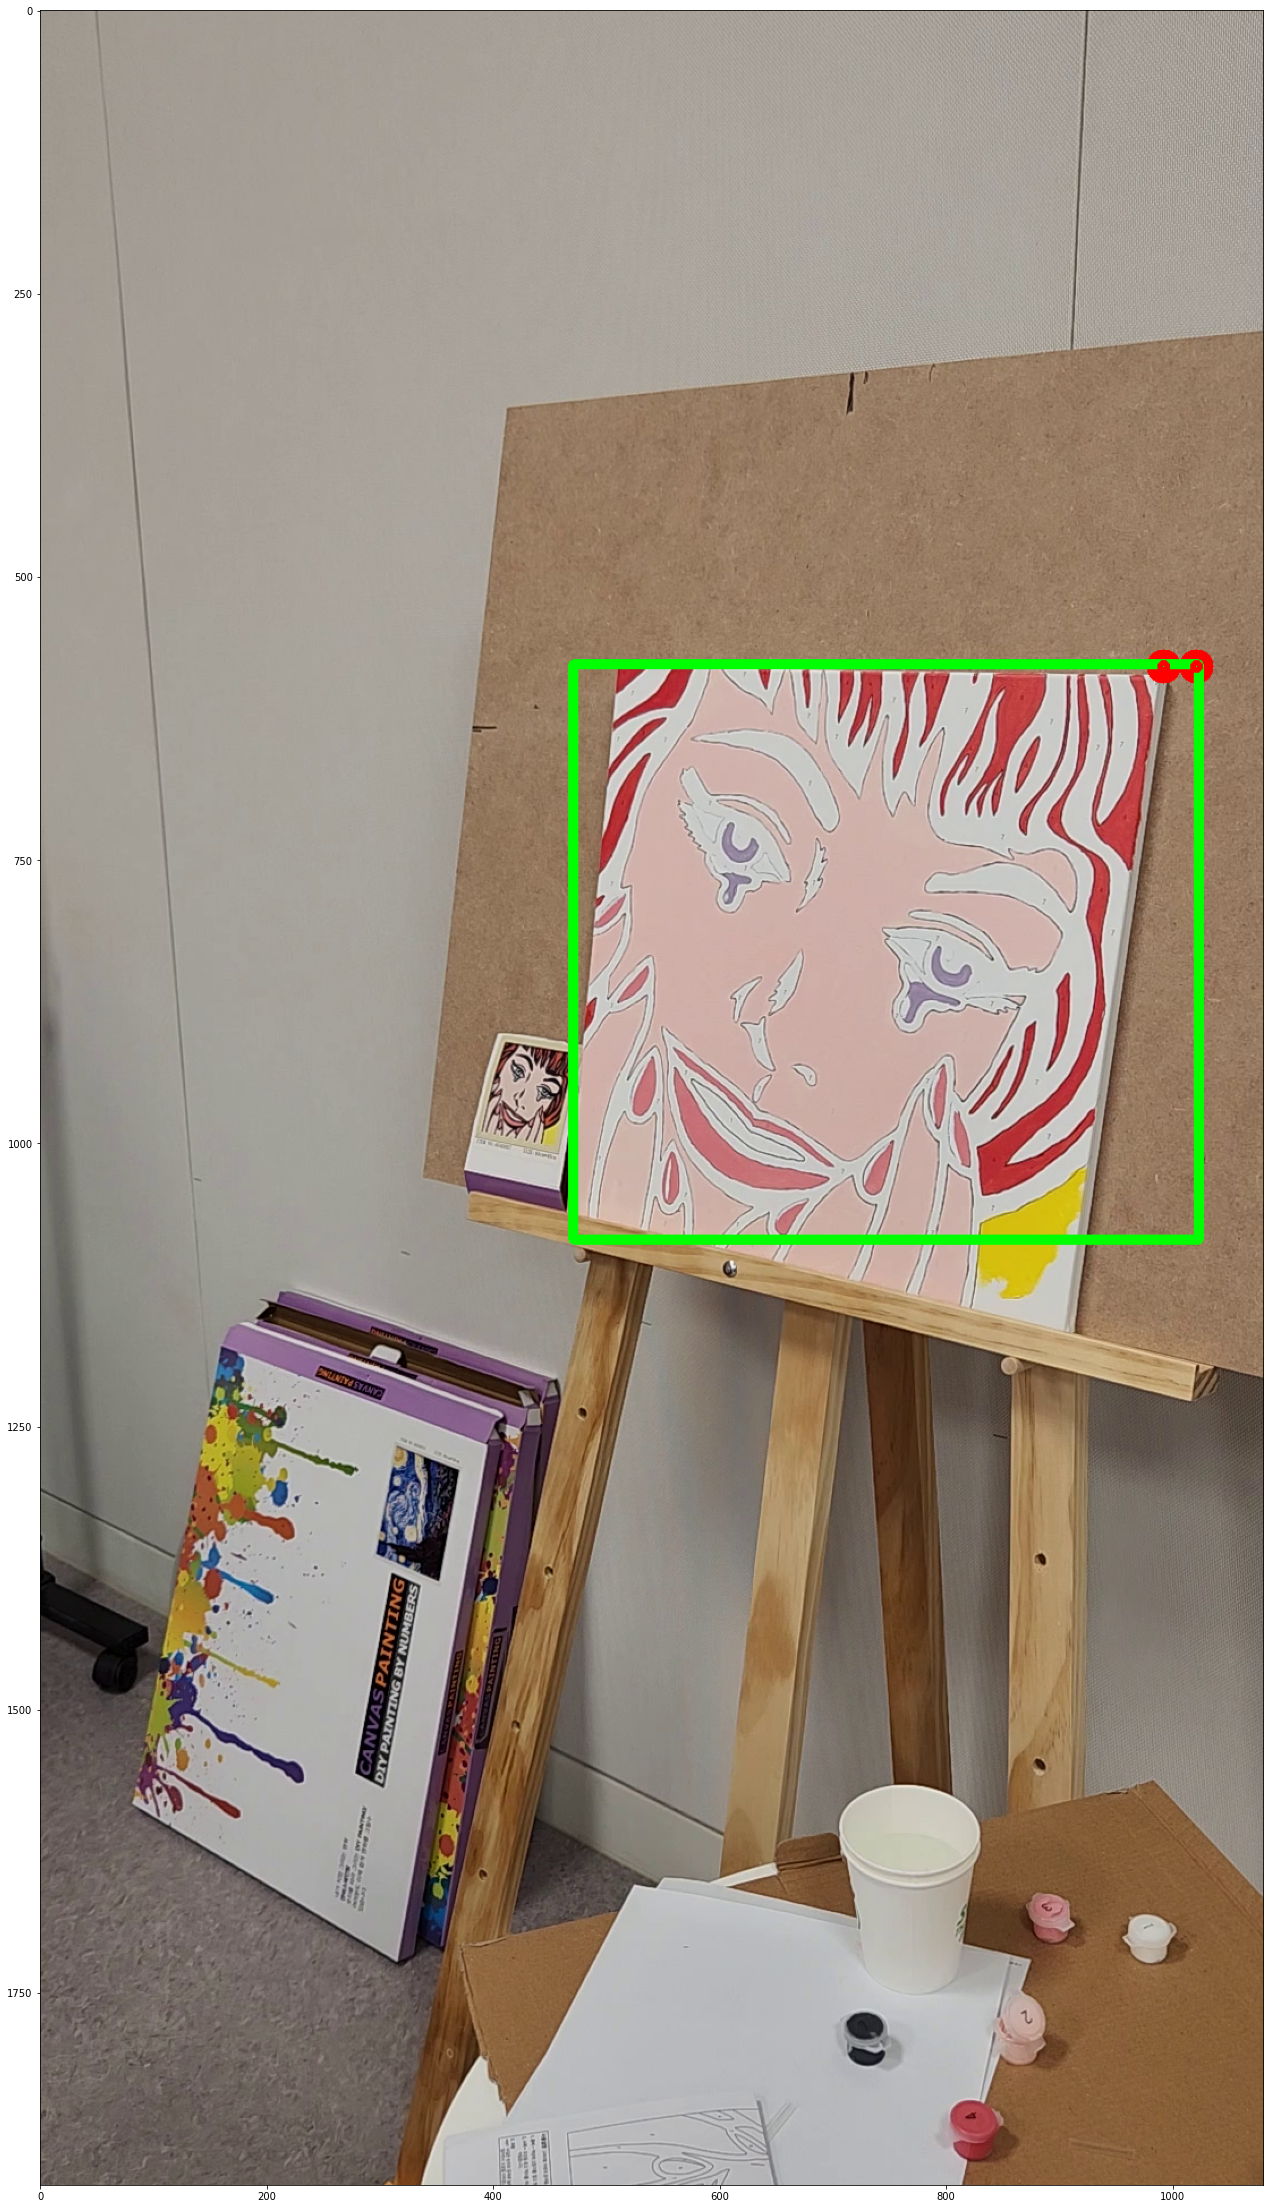

In [12]:
import cv2

# Read the image file
image = cv2.imread("./pfd_video_dataset/sample_1.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Check if the image was successfully loaded
if image is None:
    print("Error loading image")
    exit()

keypoints_main = []
bboxes_main = []

      
frame_tensor = F.to_tensor(image)
frame_tensor = frame_tensor.to(device)
images = [frame_tensor]

with torch.no_grad():
    model.to(device)
    model.eval()
    output = model(images)

frame_tensor = (images[0].permute(1,2,0).detach().cpu().numpy() * 255).astype(np.uint8)
scores = output[0]['scores'].detach().cpu().numpy()

high_scores_idxs = np.where(scores > 0.7)[0].tolist() # Indexes of boxes with scores > 0.7
post_nms_idxs = torchvision.ops.nms(output[0]['boxes'][high_scores_idxs], output[0]['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

keypoints = []
for kps in output[0]['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    keypoints.append([list(map(int, kp[:2])) for kp in kps])
    
bboxes = []
for bbox in output[0]['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy():
    bboxes.append(list(map(int, bbox.tolist())))

if(len(keypoints) != 0):
    print(keypoints)
    points = np.array(keypoints, np.int32)
    points = points.reshape((-1, 1, 2))

    # Draw a keypoints on the frame
    # cv2.polylines(frame, [points], isClosed=True, color=(0, 0, 0), thickness=8)
    for point in points:
        center = (point[0][0], point[0][1])
        radius = 15

        # Draw the keypoints using the circle() function
        cv2.circle(image, center, radius, (255, 0, 0), -1)

if(len(bboxes) != 0):
    print(bboxes)
    cv2.rectangle(image, (bboxes[0][0], bboxes[0][1]),  (bboxes[0][2], bboxes[0][3]), color=(0, 255, 0), thickness=8)

visualize(image, bboxes, keypoints)

# Display the resulting frame
# image = cv2.resize(image, (600, 800), interpolation=cv2.INTER_AREA)
# cv2.imshow('Frame', image)


# # Wait for a key press
# cv2.waitKey(0)

# # Close all windows
# cv2.destroyAllWindows()